# Daily Financial News for 6000+ Stocks
### Some Data Understanding an Preparation for Prediction of stockpricse by the Sentiment of Headlines
@author DHR <br>
@author BKN <br>
used Data in this Notebook: 'https://www.kaggle.com/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests'

## Requirements

In [5]:
#immport basic DataScience Modules
#!! for pip-modul-list to install @see requirements.txt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [6]:
#import basic topic modelling
import re
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
import gensim

import pyLDAvis
import pyLDAvis.gensim_models
import pickle 

In [7]:
#import basic visualization
from wordcloud import WordCloud, STOPWORDS
import nltk #tokenization
#nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import random

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaste\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
#imports headline cleaning
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import spacy
from nltk.corpus import sentiwordnet as snw



In [9]:
#import basic api requirements
from polygon import RESTClient
import datetime
import time
from dotenv import load_dotenv
load_dotenv()

def unique(l):
    ## list of only the unique values from a given list
    x = np.array(l)
    return np.unique(x)

In [10]:
#Load Data
data = pd.read_csv('../data/raw_analyst_ratings.csv')
#colums: id,headline,url,publisher,date,stock

## Data Understanding

No Data Cleaning

In [4]:
#first Look
print(data.columns)
data.sample(7)

Index(['id', 'headline', 'url', 'publisher', 'date', 'stock'], dtype='object')


,id,headline,url,publisher,date,stock
1139949,1145547,Skullcandy Reports Receipt of Revised Bid from...,https://www.benzinga.com/news/16/08/8356995/sk...,Paul Quintaro,2016-08-16 00:00:00,SKUL
574354,577393,5 Retailers With The Heaviest Downward Revisio...,https://www.benzinga.com/news/earnings/16/02/6...,Leigh Drogen,2016-02-23 00:00:00,GPS
206426,207787,Top 4 Stocks In The Processed And Packaged Goo...,https://www.benzinga.com/trading-ideas/long-id...,Monica Gerson,2010-07-09 00:00:00,CAG
1055319,1060531,QuickLogic Shares Spike Sharply As Traders Cir...,https://www.benzinga.com/news/19/12/14939099/q...,Benzinga Newsdesk,2019-12-05 00:00:00,QUIK
1166676,1172360,Benzinga's Top Initiations,https://www.benzinga.com/analyst-ratings/initi...,Monica Gerson,2016-02-03 00:00:00,SPLK
301366,303086,12 Financial Services Stocks Moving In Thursda...,https://www.benzinga.com/pre-market-outlook/20...,Lisa Levin,2020-02-27 00:00:00,CS
169646,170731,Jefferies & Company Maintains Blackrock at Hol...,https://www.benzinga.com/analyst-ratings/price...,webmaster,2012-04-09 00:00:00,BLK


In [13]:
#statistics
print("observations: {}, features: {} \n".format(data.shape[0], data.shape[1]))
print("unique headlines: {}, unique stocks: {} \n".format(len(data.headline.unique()), len(data.stock.unique())))

observations: 1407328, features: 6 

unique headlines: 845770, unique stocks: 6204 



In [14]:
data.count()

Unnamed: 0    1407328
headline      1407328
url           1407328
publisher     1407328
date          1407328
stock         1407328
dtype: int64

In [15]:
stock = data.groupby("stock")
stock.sample()

,Unnamed: 0,headline,url,publisher,date,stock
1394,1796,"China Crescent Enterprises, Inc. Launches $30 ...",https://www.benzinga.com/09/08/745/china-cresc...,Benzinga Staff,2009-08-07 00:00:00,A
3906,4324,"Metals Signaling Reversal? (XME, X, FCX, AA)",https://www.benzinga.com/general/10/05/299910/...,Swing Trader,2010-05-25 00:00:00,AA
4239,4668,AAC Holdings Shares Up 25% After Q4 Earnings B...,https://www.benzinga.com/news/earnings/18/02/1...,Paul Quintaro,2018-02-22 00:00:00,AAC
4335,4764,3 ADR ETFs Your Broker Forgot to Mention,https://www.benzinga.com/trading-ideas/long-id...,ETF Professor,2013-03-05 15:42:46-04:00,AADR
4661,5101,United Continental Shares Up 1% After Hours Fo...,https://www.benzinga.com/news/earnings/18/01/1...,Paul Quintaro,2018-01-23 00:00:00,AAL
...,...,...,...,...,...,...
1405521,1412042,"The Zweig Total Return Fund, Inc. Discloses So...",https://www.benzinga.com/09/08/1415/the-zweig-...,Benzinga Staff,2009-08-10 00:00:00,ZTR
1405737,1412258,Morgan Stanley Downgrades Zoetis to Equal-Weight,https://www.benzinga.com/news/18/03/11380704/m...,Eddie Staley,2018-03-19 00:00:00,ZTS
1406174,1412695,Mid-Morning Market Update: Markets Edge Higher...,https://www.benzinga.com/news/earnings/15/05/5...,Garrett Cook,2015-05-11 00:00:00,ZU
1406433,1412954,68 Stocks Moving In Thursday's Mid-Day Session,https://www.benzinga.com/news/18/08/12176160/6...,Lisa Levin,2018-08-09 00:00:00,ZUMZ


In [16]:
stock.describe()

Unnamed: 0                                                              \
           count          mean         std        min         25%        50%   
stock                                                                          
A         1433.0  8.414222e+02  572.641862        0.0      358.00      716.0   
AA        2739.0  3.208664e+03  796.519728     1835.0     2519.50     3204.0   
AAC        162.0  4.681500e+03   46.909487     4601.0     4641.25     4681.5   
AADR         2.0  4.763500e+03    0.707107     4763.0     4763.25     4763.5   
AAL        460.0  5.005261e+03  133.349498     4765.0     4890.75     5005.5   
...          ...           ...         ...        ...         ...        ...   
ZTR         19.0  1.412033e+06    5.627314  1412024.0  1412028.50  1412033.0   
ZTS        623.0  1.412354e+06  179.988889  1412043.0  1412198.50  1412354.0   
ZU         161.0  1.412746e+06   46.620811  1412666.0  1412706.00  1412746.0   
ZUMZ       955.0  1.413304e+06  275.829053  1412827.0  1413065.50  1413304.0   
ZX          67.0  1.413815e+06   19.485037  1413782.0  1413798.50  1413815.0   

                              
              75%        max  
stock                         
A         1476.00     1834.0  
AA        3902.50     4600.0  
AAC       4721.75     4762.0  
AADR      4763.75     4764.0  
AAL       5120.25     5235.0  
...           ...        ...  
ZTR    1412037.50  1412042.0  
ZTS    1412509.50  1412665.0  
ZU     1412786.00  1412826.0  
ZUMZ   1413542.50  1413781.0  
ZX     1413831.50  1413848.0  

[6204 rows x 8 columns]

In [17]:
data['date']

0          2020-06-05 10:30:54-04:00
1          2020-06-03 10:45:20-04:00
2          2020-05-26 04:30:07-04:00
3          2020-05-22 12:45:06-04:00
4          2020-05-22 11:38:59-04:00
                     ...            
1407323          2011-08-29 00:00:00
1407324          2011-06-22 00:00:00
1407325          2011-06-21 00:00:00
1407326          2011-06-21 00:00:00
1407327          2011-05-12 00:00:00
Name: date, Length: 1407328, dtype: object

### Data Visualization

<AxesSubplot:>

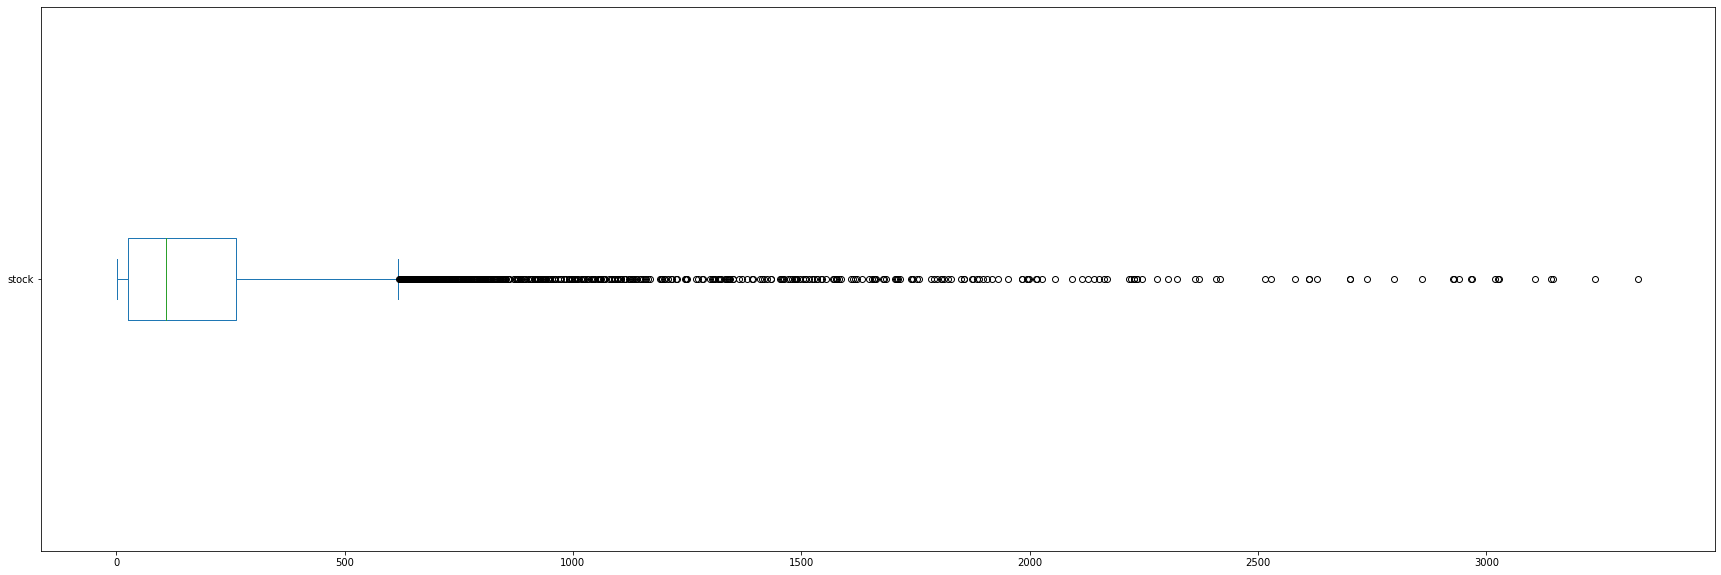

In [18]:
# BoxPlot of Stocks
data['stock'].value_counts().plot.box(vert=False, figsize=(30,10))

<AxesSubplot:>

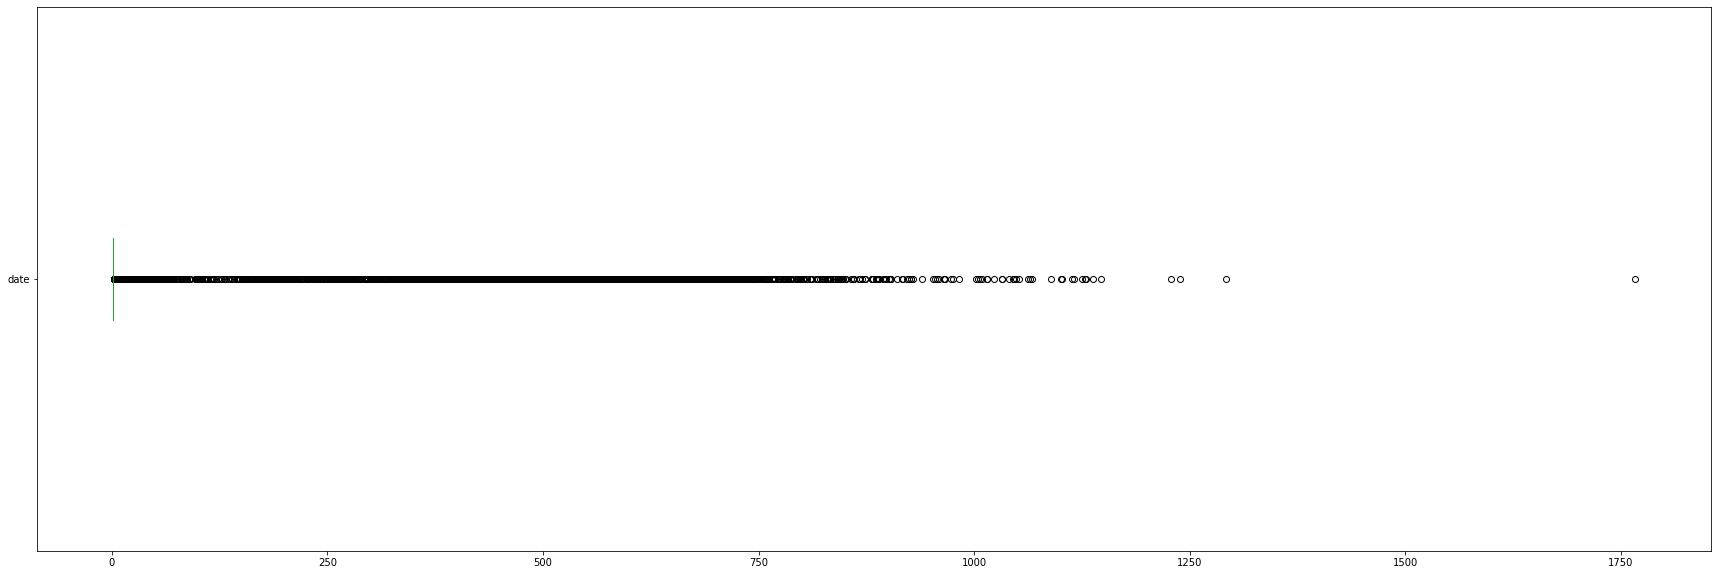

In [19]:
# BocPlot of Date
data['date'].value_counts().plot.box(vert=False, figsize=(30,10))

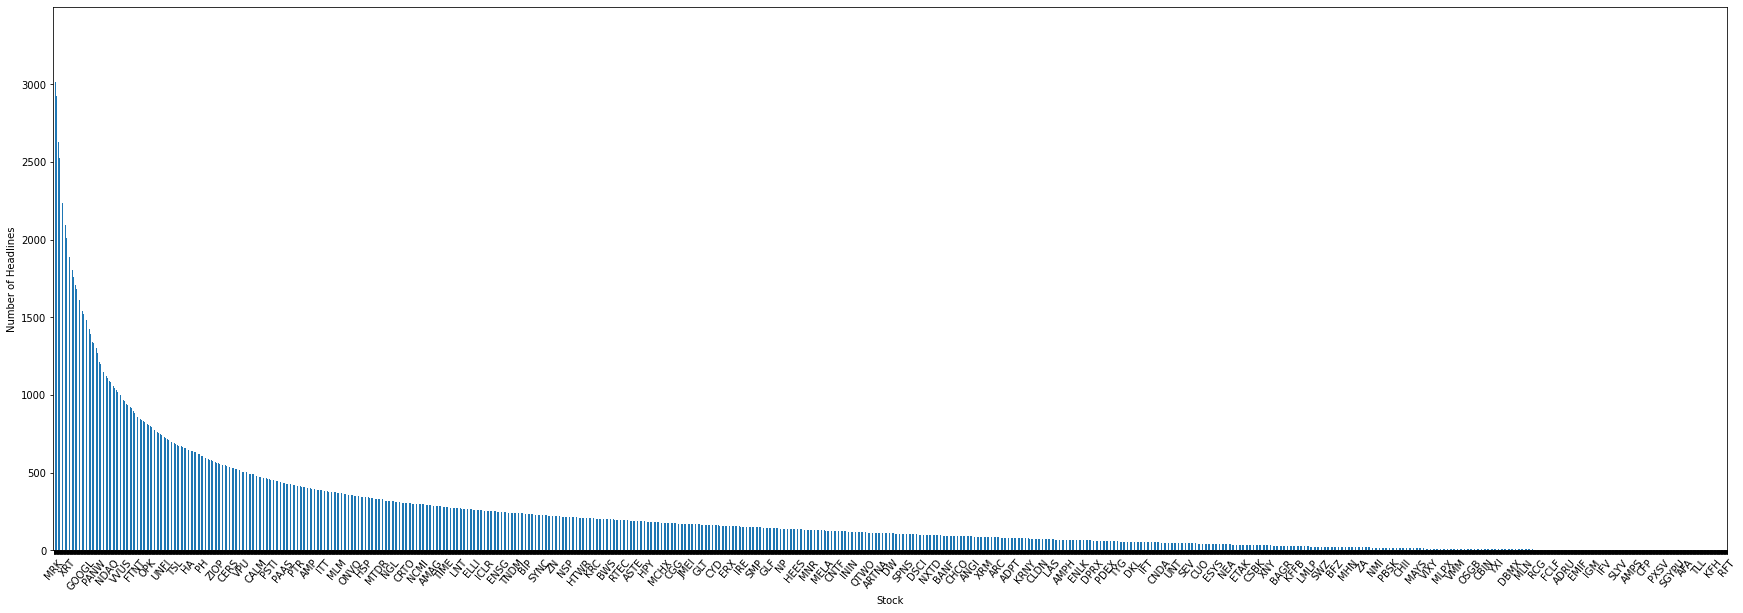

In [20]:
# Number of Headlines by Stock
plt.figure(figsize=(30,10))
ax = stock.size().sort_values(ascending=False)[0:6204].plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Stock")
plt.ylabel("Number of Headlines")
#only display every n Label
n = 50
for i, t in enumerate(ax.get_xticklabels()):
    if (i % n) != 0:
        t.set_visible(False)
plt.show()

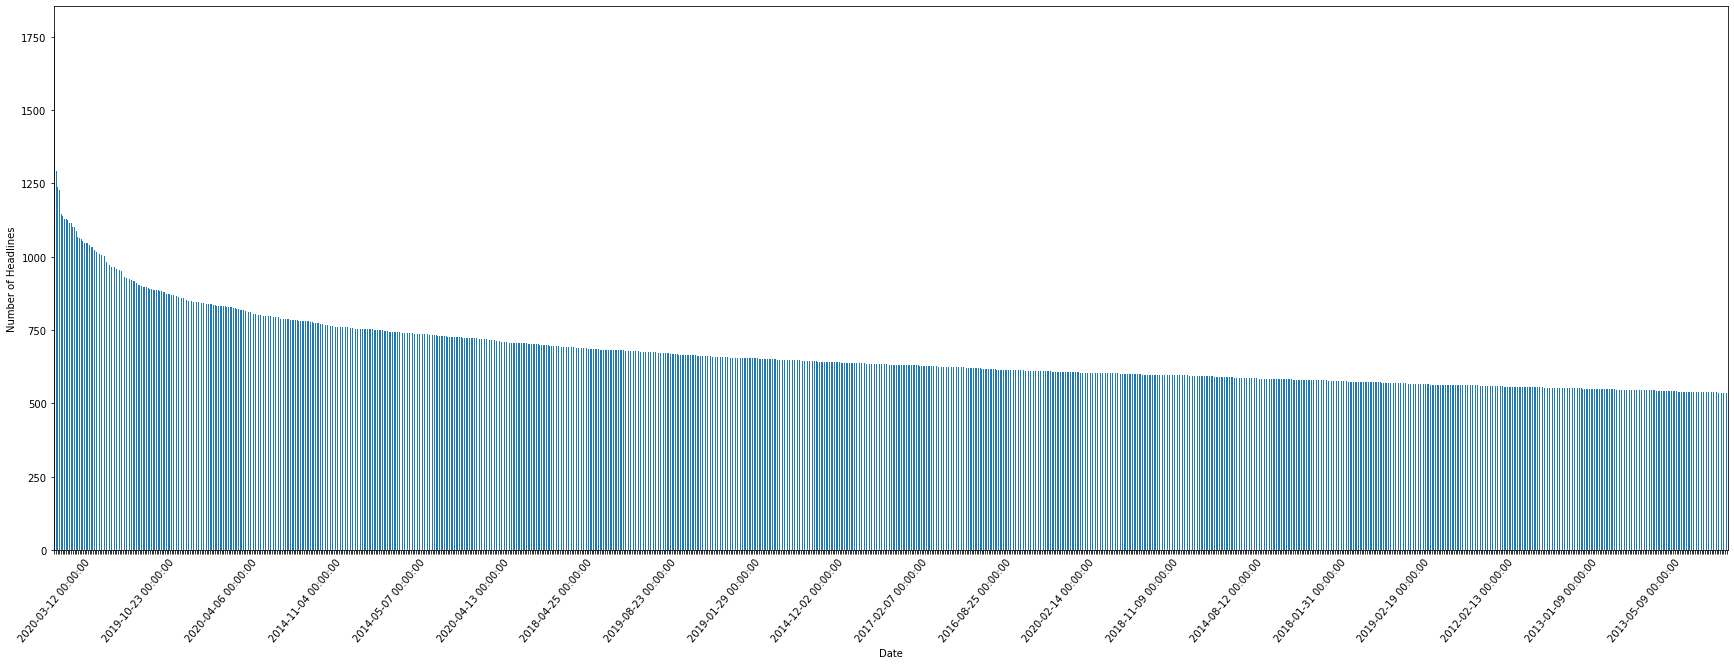

In [21]:
# Number of Headlines by Date
date = data.groupby("date")

plt.figure(figsize=(30,10))
ax = date.size().sort_values(ascending=False)[0:1000].plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Date")
plt.ylabel("Number of Headlines")

#only display every n Label
n = 50
for i, t in enumerate(ax.get_xticklabels()):
    if (i % n) != 0:
        t.set_visible(False)
plt.show()

In [22]:
date_withYear = data.assign(year = lambda dataframe: dataframe['date'].map(lambda date: date[0:4]))

In [23]:
print("Der Datensatz erstreckt sich über einen Datumsspanne vom "+ data['date'].min()[0:10] +" bis zum "+ data['date'].max()[0:10] +"\nDabei besteht der Datensatz aus "+ str(data.headline.count()) + " Einträgen")

Der Datensatz erstreckt sich über einen Datumsspanne vom 2009-02-14 bis zum 2020-06-11
Dabei besteht der Datensatz aus 1407328 Einträgen


Text(0, 0.5, 'Number of Healines')

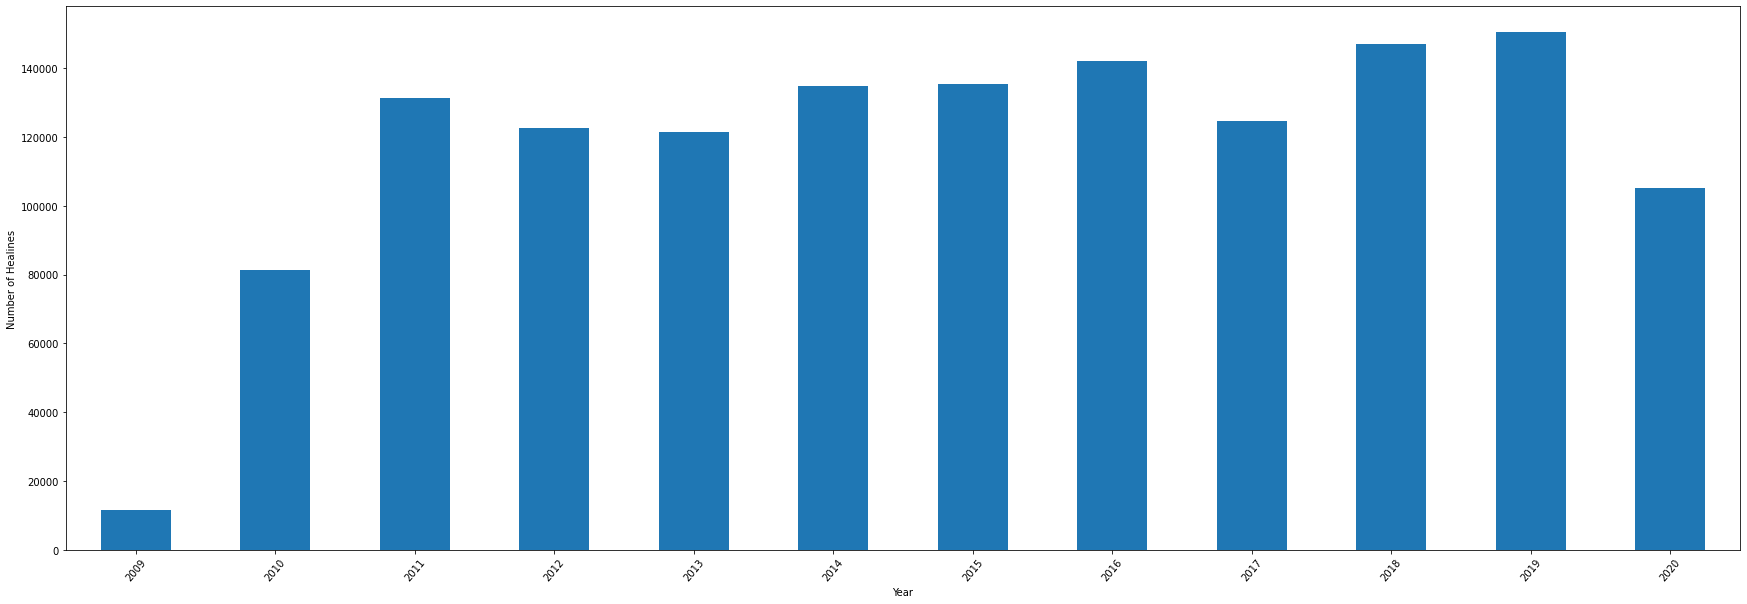

In [24]:
# Number of Date by Year
year = date_withYear.groupby("year")

plt.figure(figsize=(30,10))
year.size().plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Year")
plt.ylabel("Number of Healines")

In [25]:
import statistics

print(statistics.mean(year.size()))

117277.33333333333


In [26]:
# Termdocument Matrix

# all headlines as String in List
docs = []
for headline in data.headline:
    docs.append(headline)
docs = docs[0:1000]

vec = CountVectorizer()
X = vec.fit_transform(docs)
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
print(df)

# !! TDM just useful for stemmend and removed Stopwords dataset

     00  000  014b  015b  01b  01m  02b  02m  03  03b  ...  yo  you  young  \
0     0    0     0     0    0    0    0    0   0    0  ...   0    0      0   
1     0    0     0     0    0    0    0    0   0    0  ...   0    0      0   
2     0    0     0     0    0    0    0    0   0    0  ...   0    0      0   
3     0    0     0     0    0    0    0    0   0    0  ...   0    0      0   
4     0    0     0     0    0    0    0    0   0    0  ...   0    0      0   
..   ..  ...   ...   ...  ...  ...  ...  ...  ..  ...  ...  ..  ...    ...   
995   0    0     0     0    0    0    0    0   0    0  ...   0    0      0   
996   0    0     0     0    0    0    0    0   0    0  ...   0    0      0   
997   0    0     0     0    0    0    0    0   0    0  ...   0    0      0   
998   0    0     0     0    0    0    0    0   0    0  ...   0    0      0   
999   0    0     0     0    0    0    0    0   0    0  ...   0    0      0   

     your  yoy  yum  zacks  zoll  zone  zoom  
0       0    0  

#### Wordclouds before Data Cleaning

In [27]:
# Wordcloud for all Headlines

#combine all headlines to one text
text = " ".join(headline for headline in data.headline)
maxWords = 50
#wordcloud
#!! No Stopword removal
# stopwords = STOPWORDS
# stopwords.update(["Benzinga", "Stocks", "vs", "Est", "EPS"])
wordcloud = WordCloud(max_words=maxWords).generate(text)

#plot
print("WorldCloud over all Stocks, Top " + str(maxWords) + " Words:")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#save
wordcloud.to_file("./results/wordcloud.png")

KeyboardInterrupt: 

WorldCloud for Random Stock: DBC, Top 50 Words:


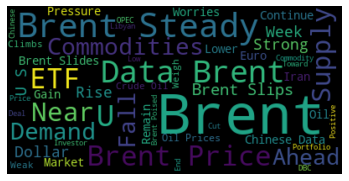

In [28]:
# Wordcloud for one Stock

#combine all headlines of one Stock
stockFilter = random.choice(unique(data['stock']))
maxWords = 50
text_SpecificStock = " ".join(headline for headline in data[data["stock"]==stockFilter].headline)

#wordcloud
#!! No Stopword removal
wordcloud = WordCloud(max_words=maxWords).generate(text_SpecificStock)

#plot
print("WorldCloud for Random Stock: " + stockFilter + ", Top " + str(maxWords) + " Words:")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#save
wordcloud.to_file("./results/wordcloud_stock-"+ stockFilter +".png")

In [29]:
# Top n-Words
n = 20

wordFreq = WordCloud().process_text(text)
wordFreq = dict(sorted(wordFreq.items(), key=lambda item: item[1], reverse=True)[:n])

plt.bar(range(len(wordFreq)), list(wordFreq.values()), align='center')
plt.xticks(range(len(wordFreq)), list(wordFreq.keys()), rotation=50)
plt.show()

KeyboardInterrupt: 

#### Topic Modelling before Data Cleaning

In [ ]:
# Topic Modelling with topicCount Topics
topicCount = 10

## Necessary Text Cleaning
# Remove punctuation
# data['headline_processed'] = \
# data['headline'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
# data['headline_processed'] = \
# data['headline_processed'].map(lambda x: x.lower())

# stop_words = stopwords.words('english')
# stop_words.extend(['bezinga', 'stock'])

## Necessary Tokenzisation of Sentences to Words
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(simple_preprocess(str(sentence), deacc=True))
# def remove_stopwords(texts):
#     return [[word for word in simple_preprocess(str(doc)) 
#              if word not in stop_words] for doc in texts]


headline = data.headline.values.tolist() #use headline_processed instead of headline for a little bit of DataCleaning
headline_words = list(sent_to_words(headline))
# remove stop words
# headline_words = remove_stopwords(headline_words)

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(headline_words)
# Create Corpus
texts = headline_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [ ]:
# The Real Topic Modelling
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=topicCount)
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
# Visualization of the Topic Modelling

pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./app/results_ldavis_prepared_'+str(topicCount))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './app/results_ldavis_prepared_'+ str(topicCount) +'.html')
LDAvis_prepared

### Data Quality

In [30]:
# count all null values in the DataFrame
print("Anzahl von null Werten im gesamten DataFrame: "+str(data.isna().sum().sum()))

Anzahl von null Werten im gesamten DataFrame: 0


In [31]:
# count all dates without time, no need to format in isoFormat
print("Anzahl Zeitstempel ohne konkrete Uhrzeit: "+ str(data['date'].str.count('00:00:00').sum()))

Anzahl Zeitstempel ohne konkrete Uhrzeit: 1351341


In [32]:
# count duplicated
print("Anzahl Doppelten Einträgen: "+ str(data.duplicated().sum()))

Anzahl Doppelten Einträgen: 0


## Data Preparation

### Clean

In [33]:
# format datetime to date
data = data.assign(
    date = lambda dataframe: dataframe['date'].map(lambda date: date[0:10])
)

# delete all rows older than 2years
data = data.drop(data[data.date < '2019-08-21'].index)


In [34]:
print("Der Datensatz erstreckt sich nun über einen Datumsspanne vom "+ data['date'].min() +" bis zum "+ data['date'].max() +"\nDabei besteht der Datensatz jetzt aus "+ str(data.headline.count()) + " Einträgen")

Der Datensatz erstreckt sich nun über einen Datumsspanne vom 2019-08-21 bis zum 2020-06-11
Dabei besteht der Datensatz jetzt aus 164698 Einträgen


## Headline Cleaning
### Hier wird nochmal speziell jede einzelene Headline mit WordNet den typischen pre-processing Schritten unterzogen

In [181]:
#Daten laden und eine weitere Spalte mit den gecleanten Headlines erstelleb
data_important = data
data_temp = data_important['headline'].copy()

data_important['headlines_cleaned'] = data_temp

data_important.head()

,Unnamed: 0,headline,url,publisher,date,stock,headlines_cleaned
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A,Stocks That Hit 52-Week Highs On Friday
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A,Stocks That Hit 52-Week Highs On Wednesday
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A,71 Biggest Movers From Friday
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A,46 Stocks Moving In Friday's Mid-Day Session
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A,B of A Securities Maintains Neutral on Agilent...


In [182]:
#wordnet laden und funktionen für Lowercase und Stopword-removal und Tokenization
nltk.download('wordnet')

def lowercase(headline):
    return headline.lower()
    
#function for removing stopwords and tokenize using Wordnet

def remove_stopwords_tokenize(headline):
    word_tokenz = word_tokenize(headline)
    stop_words = set(stopwords.words('english')) 

    #add some custom stopword here
    # stop_words.add('')

    filtered_sentence = [word for word in word_tokenz if not word in stop_words]
    return filtered_sentence
    


    



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kaste\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [183]:
#Headlines lowercase machen .... ja das geht auch mit lambda
data_important['headlines_cleaned'] = data_important['headlines_cleaned'].apply(lowercase)
data_important.head()


,Unnamed: 0,headline,url,publisher,date,stock,headlines_cleaned
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A,stocks that hit 52-week highs on friday
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A,stocks that hit 52-week highs on wednesday
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A,71 biggest movers from friday
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A,46 stocks moving in friday's mid-day session
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A,b of a securities maintains neutral on agilent...


In [184]:
#jetzt das stopword removal mit tokenization
#!! das kann etwas zeitaufwendig sein, deshalb wird das Ergebnis im nächsten Schritt als csv exportiert und liegt im Ordner ab.
data_important['headlines_cleaned'] = data_important['headlines_cleaned'].apply(remove_stopwords_tokenize)
data_important.head()

,Unnamed: 0,headline,url,publisher,date,stock,headlines_cleaned
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A,"[stocks, hit, 52-week, highs, friday]"
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A,"[stocks, hit, 52-week, highs, wednesday]"
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A,"[71, biggest, movers, friday]"
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A,"[46, stocks, moving, friday, 's, mid-day, sess..."
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A,"[b, securities, maintains, neutral, agilent, t..."


In [185]:
#Export als csv
data_important.to_csv('../data/zwischenergebnis_stopwords_tokenized.csv', index=False)

In [172]:
#Hier eine Lemmatisierungsfunktion mit dem WortNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize(headline_tokenz):
    lemmatized_output = [lemmatizer.lemmatize(word) for word in headline_tokenz]

    #Alle Wörter mit weniger als zwei Zeichen weg
    lemmatized_output = [word for word in lemmatized_output if len(word) > 2]

    #Alle Zahlen entfernen
    lemmatized_output = [word for word in lemmatized_output if not word.isnumeric()]

    return lemmatized_output


In [187]:
#lemmatization durchführen

#nächste Zeile um daten zu laden
# data_important = pd.read_csv('../data/zwischenergebnis_stopwords_tokenized.csv')
data_important['headlines_cleaned'] = data_important['headlines_cleaned'].apply(lemmatize)
data_important.head()

In [ ]:
#Export als csv
data_important.to_csv('../data/zwischenergebnis_lemmatized.csv', index=False)

In [174]:
#wieder in ganzen satz umwandeln
data_important['headlines_cleaned'] = data_important['headlines_cleaned'].apply(lambda headline_tokenz: " ".join(headline_tokenz))
data_important.head()

C:\Users\kaste\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,Unnamed: 0,headline,url,publisher,date,stock,headlines_cleaned
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A,stock hit 52-week high friday
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A,stock hit 52-week high wednesday
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A,biggest mover friday
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A,stock moving friday mid-day session
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A,security maintains neutral agilent technology ...


In [180]:
#als csv exportieren
data_important.to_csv('../data/analyst_ratings_processed_hl_cleaned.csv', index=False )

In [36]:
# clean the Stocks
# Remove Rows with Stocks that occur less than occ times
occ = 0
data = data[data.groupby('stock').stock.transform(len) > occ]

### Construct

#### API call to get StockPrices for all stocks that occur more than 10 times
used API : 'https://polygon.io/'
(need timeouts because of max 5 Api calls per Minute)

In [13]:
# List of Stock Ticker to call
stocks_unique = unique(data['stock'])
print("Es verbleiben "+str(len(stocks_unique))+" eindeutige Stocks, zur Anfrage an der API, welche im Zeitraum der Verfügbaren API liegen")

Es verbleiben 3807 eindeutige Stocks, zur Anfrage an der API, welche im Zeitraum der Verfügbaren API liegen


In [14]:
# API call with TimeOut (5 per minute)
key = os.environ.get("POLYGON_IO_API_KEY")
apiResults = []
apiCount = 0

for s in stocks_unique:
    # the API only response to 2years historical dates
    from_ = '2019-08-21'
    to =  '2020-12-31'

    #The API call
    with RESTClient(key) as client:
        resp = client.stocks_equities_aggregates(s, 1, "day", from_, to, unadjusted=False)
        # save the nessecary attributes of the JSON as List
        if (resp and hasattr(resp, 'results')):
            for result in resp.results:
                dt = datetime.datetime.fromtimestamp(result['t'] / 1000.0).isoformat()
                apiResults.append([s, dt, result['o'], result['h'], result['l'], result['c']])
        else: 
            apiResults.append([s])
            print("["+datetime.datetime.now().isoformat() +"]" + " - API-Call Nr. " + str(apiCount) + " for Stock: " + s + " ___no_Results___")
    apiCount+=1
    print("["+datetime.datetime.now().isoformat() +"]" + " - API-Call Nr. " + str(apiCount) + " for Stock: " + s + " ___success___")
    time.sleep(12)

#save the List-Data as DataFrame
stock_prices = pd.DataFrame(apiResults, columns=['stock', 'date', 'open', 'high', 'low', 'close'])
#save the DataFrame as csv
stock_prices.to_csv('../data/raw_stock_prices.csv', encoding='utf-8', index=False)

[2021-08-01T09:52:46.054350] - API-Call Nr. 1 for Stock: A ___success___
[2021-08-01T09:52:58.498410] - API-Call Nr. 2 for Stock: AA ___success___
[2021-08-01T09:53:11.090924] - API-Call Nr. 3 for Stock: AAC ___success___
[2021-08-01T09:53:23.562948] - API-Call Nr. 4 for Stock: AAL ___success___
[2021-08-01T09:53:36.228791] - API-Call Nr. 5 for Stock: AAMC ___success___
[2021-08-01T09:53:54.953673] - API-Call Nr. 6 for Stock: AAME ___success___
[2021-08-01T09:54:07.669270] - API-Call Nr. 7 for Stock: AAN ___success___
[2021-08-01T09:54:20.357240] - API-Call Nr. 8 for Stock: AAOI ___success___
[2021-08-01T09:54:38.426408] - API-Call Nr. 9 for Stock: AAON ___success___
[2021-08-01T09:54:50.866599] - API-Call Nr. 10 for Stock: AAP ___success___
[2021-08-01T09:55:03.559560] - API-Call Nr. 11 for Stock: AAPL ___success___
[2021-08-01T09:55:16.283950] - API-Call Nr. 12 for Stock: AAWW ___success___
[2021-08-01T09:55:28.660863] - API-Call Nr. 13 for Stock: AB ___success___
[2021-08-01T09:55:4

In [11]:
#get the API data from the csv to DataFrame
stock_prices = pd.read_csv('../data/raw_stock_prices.csv')

## Overview of the API Data

Remove Stocks that has no Results from DataFrame Stock_prices and Data

In [12]:
stock_prices.count()

stock    1227563
date     1227498
open     1227498
high     1227498
low      1227498
close    1227498
dtype: int64

In [39]:
stock_prices.sample(7)

,stock,date,open,high,low,close
153878,BQH,2020-06-30T06:00:00,15.60,15.710,15.600,15.71
603718,JJSF,2019-11-13T06:00:00,182.18,184.475,181.000,183.64
81899,ASRV,2020-05-11T06:00:00,2.95,3.140,2.920,2.92
721330,MOH,2020-12-18T06:00:00,204.86,204.860,199.400,201.96
132162,BIB,2019-12-05T06:00:00,61.18,61.190,59.480,60.01
847214,PCH,2020-02-18T06:00:00,41.84,41.955,41.370,41.87
623278,KIM,2020-06-12T06:00:00,13.48,13.860,12.985,13.76


In [45]:
# count NaN rows
nanStocks = stock_prices[stock_prices['open'].isna() & stock_prices['close'].isna()]['stock']
print("Total Count of Stocks with NaN: " + str(len(nanStocks)))

Total Count of Stocks with NaN: 0


In [46]:
# remove headlines with NaN stock prices
data = data.drop(data[data['stock'].isin(nanStocks)].index)

# remove NaN stocks
stock_prices = stock_prices.drop(stock_prices[stock_prices.open.isna() & stock_prices.close.isna()].index)

In [43]:
# count NaN each Column
stock_prices.isnull().sum()

stock    0
date     0
open     0
high     0
low      0
close    0
dtype: int64

In [44]:
data.count()

Unnamed: 0    164415
headline      164415
url           164415
publisher     164415
date          164415
stock         164415
dtype: int64

In [72]:
stock_prices.count()

stock    1227498
date     1227498
open     1227498
high     1227498
low      1227498
close    1227498
dtype: int64

## Combine DataFrame

Join on stock and date +- x

In [78]:
#! Don't do this !
#! No API Data for Weekends! 
# days before and after
x = 1
# add Date before
data = data.assign(
    date_before = lambda dataframe: dataframe['date'].map(lambda date: date.replace(date[8:10], str(int(date[8:10])+x)))
)
# add Date after
data = data.assign(
    date_after = lambda dataframe: dataframe['date'].map(lambda date: date.replace(date[8:10], str(int(date[8:10])-x)))
)

# JOIN
headlines_with_StockPrices = pd.merge(data, stock_prices, left_on=['stock', 'date_before'], right_on=['stock', 'date'], how='left', suffixes=('', '_before'))
headlines_with_StockPrices = pd.merge(headlines_with_StockPrices, stock_prices, left_on=['stock', 'date_after'], right_on=['stock', 'date'], how='left', suffixes=('', '_after'))
# headlines_with_StockPrices.drop(['stock_before', 'stock_after'], 1)

### Format

In [73]:
# format datetime to date
stock_prices = stock_prices.assign(
    date = lambda dataframe: dataframe['date'].map(lambda date: date[0:10])
)

## Data Understanding: Visualization after Cleaning

## Headlines Preprocessing



In [13]:
data.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


#### Wordclouds after Data Cleaning

#### Topic Modelling after Data Cleaning

## Modeling